In [0]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

start = datetime.datetime(2010, 12, 1)
end = datetime.datetime(2019, 9, 6)

df = web.DataReader("FB", 'yahoo', start, end)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,186.800003,183.460007,186.779999,185.669998,10774500,185.669998
2019-09-03,185.669998,182.110001,184.000000,182.389999,9779400,182.389999
2019-09-04,187.750000,183.889999,184.649994,187.139999,11308000,187.139999
2019-09-05,191.360001,187.940002,188.529999,190.899994,13876700,190.899994
2019-09-06,190.210007,186.350006,190.210007,187.490005,15219500,187.490005


In [0]:
# select only close column
close = df[['Close']]
close.tail()

,Close
Date,
2019-08-30,185.669998
2019-09-03,182.389999
2019-09-04,187.139999
2019-09-05,190.899994
2019-09-06,187.490005


In [0]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg.tail()

Date
2019-08-30    187.4009
2019-09-03    187.4466
2019-09-04    187.5429
2019-09-05    187.6609
2019-09-06    187.7393
Name: Adj Close, dtype: float64

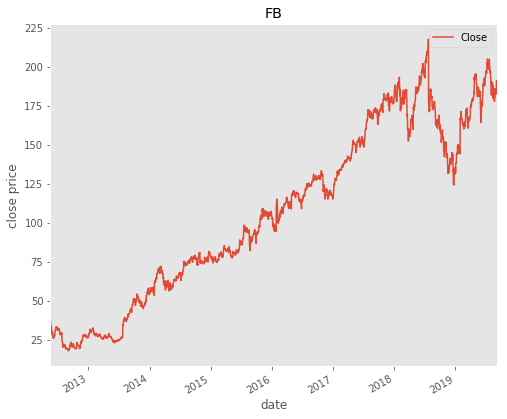

In [0]:
# rename the column with symbole name
ax = close.plot(title='FB')
ax.set_xlabel('date')
ax.set_ylabel('close price')
ax.grid()
plt.show()

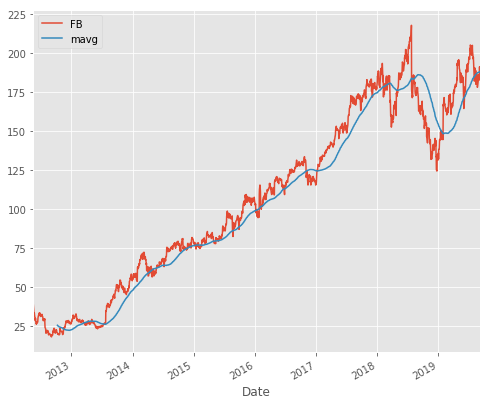

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='FB')
mavg.plot(label='mavg')
plt.legend()

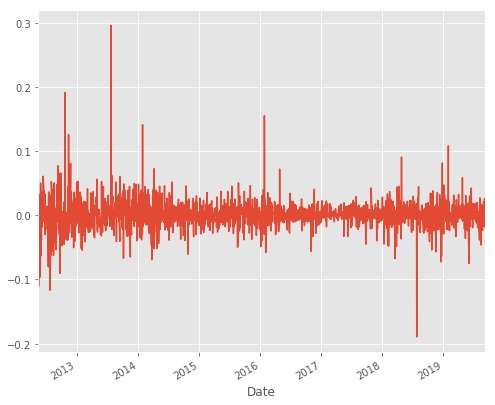

In [0]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [0]:
dfcomp = web.DataReader(['FB', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,FB,GOOG,IBM,MSFT
Date,,,,
2019-08-30,185.669998,1188.099976,135.529999,137.860001
2019-09-03,182.389999,1168.390015,134.100006,136.039993
2019-09-04,187.139999,1181.410034,136.320007,137.630005
2019-09-05,190.899994,1211.380005,140.970001,140.050003
2019-09-06,187.490005,1204.930054,140.570007,139.100006


In [0]:
#correlation

retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr.tail()

Symbols,FB,GOOG,IBM,MSFT
Symbols,,,,
FB,1.000000,0.414003,0.197599,0.310229
GOOG,0.414003,1.000000,0.399091,0.542114
IBM,0.197599,0.399091,1.000000,0.476025
MSFT,0.310229,0.542114,0.476025,1.000000


Text(0, 0.5, 'Returns GOOG')

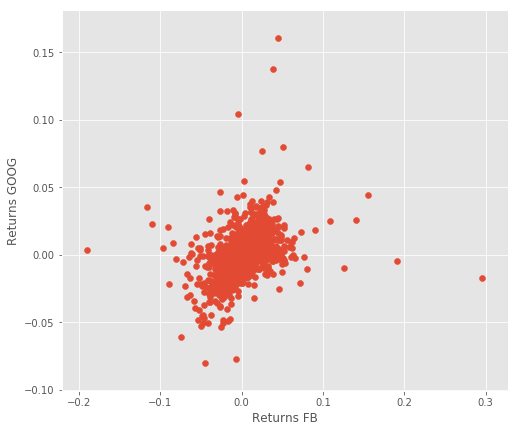

In [0]:
#plot FB and GOOG

plt.scatter(retscomp.FB, retscomp.GOOG)
plt.xlabel('Returns FB')
plt.ylabel('Returns GOOG')

In [0]:
#feature engineering
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-30,185.669998,10774500,1.798889,-0.594282
2019-09-03,182.389999,9779400,1.951860,-0.875000
2019-09-04,187.139999,11308000,2.062627,1.348500
2019-09-05,190.899994,13876700,1.791513,1.257092
2019-09-06,187.490005,15219500,2.058777,-1.429999


In [0]:
import math
import numpy as np
from sklearn import preprocessing

#preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_test = X[-forecast_out:]
X_train = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [0]:
#model generation
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [0]:
y_pred_test = clfreg.predict(X_test)
y_pred_train = clfreg.predict(X_train)

In [0]:
forecast_set = clfreg.predict(X_test)
dfreg['Forecast'] = np.nan
print(forecast_set)

[186.22429297 189.16645721 180.8763724  183.32741823 184.47599641
 186.94410025 184.73009386 184.45410423 182.99269433 178.84403423
 181.18218669 182.12130159 182.57664546 186.27663436 186.51702694
 183.33320156 187.83329457 191.48343541 188.32573371]


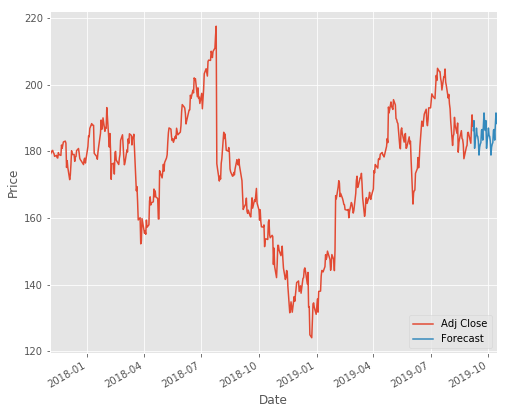

In [0]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()